In [3]:
import warnings

import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
import string

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 


import os
import sys

from numpy.typing import ArrayLike
from typing import Optional, Callable, List, Tuple, Dict

warnings.filterwarnings('ignore')

import constants
from constants import PlotConfig
sys.path.append(constants.MODULE_DIR)
import sn_plotting
import xarray_class_accessors as xca
import utils
import stats
import xarray_extender as xce
import signal_to_noise as sn
import open_ds
from classes import ExperimentTypes, LocationsLatLon
import plotting_functions
logger = utils.get_notebook_logger()

In [4]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]

In [5]:
TEST_SAVE_DIR = os.path.join(constants.LONGRUNMIP_DIR, experiment_params['variable'], 'method_test')

In [41]:
files_to_open = os.listdir(TEST_SAVE_DIR)
files_to_open

['control_rolling_static_order_5_window_20.nc',
 'abrupt4x_polynomial_static_order_6_window_20.nc',
 'control_polynomial_static_order_5_window_20.nc',
 'abrupt4x_polynomial_static_order_3_window_20.nc',
 'control_rolling_static_order_4_window_20.nc',
 'abrupt4x_polynomial_static_order_4_window_20.nc',
 'abrupt4x_polynomial_rolling_order_3_window_20.nc',
 'abrupt4x_polynomial_rolling_order_4_window_20.nc',
 'control_polynomial_static_order_3_window_20.nc',
 'control_polynomial_static_order_6_window_20.nc',
 'static_window_21_double_polynomial.nc',
 'abrupt4x_polynomial_rolling_order_5_window_20.nc',
 'abrupt4x_polynomial_rolling_order_6_window_20.nc',
 'abrupt4x_polynomial_static_order_5_window_20.nc',
 'control_polynomial_static_order_4_window_20.nc',
 'control_rolling_static_order_3_window_20.nc',
 'control_rolling_static_order_6_window_20.nc']

In [103]:
def open_files(files_to_open, needed_string=None, to_remove=None):
    if needed_string: files_to_open = [f for f in files_to_open if needed_string in f]

    da_list = []
    names = []
    for fname in files_to_open:

        da = xr.open_dataarray(os.path.join(TEST_SAVE_DIR, fname)).squeeze().drop(
            ['window', 'height'], errors='ignore')
        var_name = fname.split('.')[0]
        if needed_string: var_name = var_name.replace(needed_string, '')
        if var_name[0] == '_': var_name = var_name[1:]
        if to_remove: var_name = var_name.replace(to_remove, '')
        if 'rolling' in var_name and 'static' in var_name: var_name = var_name.replace('static_', '')
        #da.name = var_name
        names.append(var_name)
        da_list.append(da.chunk({'time':-1}))
        
    return xr.concat(da_list, pd.Index(names, name='var_type'))#xr.merge(da_list)

In [104]:
exp_ds = open_files(files_to_open, 'abrupt4x', to_remove='polynomial_').dropna(dim='time')
control_ds = open_files(files_to_open, 'control', to_remove='polynomial_').dropna(dim='time')

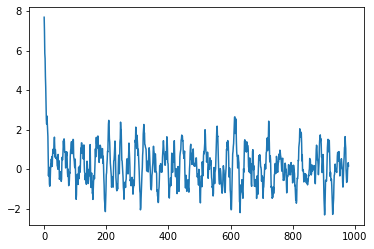

In [106]:
plt.plot(exp_ds.isel(model=0, var_type=0).sel(lat=-38, lon=144, method='nearest').values)#.plot()

In [107]:
np.sort(list(exp_ds.var_type.values)) == np.sort(list(control_ds.var_type.values))

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [108]:
lower_bound, upper_bound = sn.calculate_upper_and_lower_bounds(control_ds.chunk({'time':-1}), logginglevel='INFO')

- Calculating Upper and lower control bounds
- Map blocks used


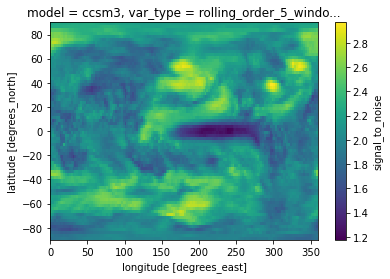

In [110]:
upper_bound.isel(var_type=0, model=0).plot()

In [112]:
unstable_ds = xr.where(np.logical_or(exp_ds > upper_bound, exp_ds < lower_bound), exp_ds, np.nan).persist()
stable_ds = xr.where(np.logical_and(exp_ds < upper_bound, exp_ds > lower_bound), exp_ds, np.nan).persist()

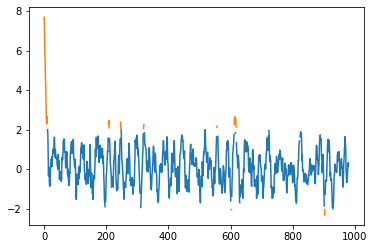

In [116]:
plt.plot(stable_ds.isel(var_type=0, model=0).sel(lat=-38, lon=144, method='nearest').values)
plt.plot(unstable_ds.isel(var_type=0, model=0).sel(lat=-38, lon=144, method='nearest').values)

In [117]:
stable_number_da = sn.number_finite(stable_ds)
unstable_number_da = sn.number_finite(unstable_ds)
stable_number_da.name = 'stable'
unstable_number_da.name = 'unstable'

number_stable = xr.merge([stable_number_da, unstable_number_da])

In [118]:
number_stable

<xarray.Dataset>
Dimensions:   (time: 981, lon: 144, lat: 72, var_type: 8)
Coordinates:
  * time      (time) object 0002-12-31 00:00:00 ... 0982-12-31 00:00:00
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * var_type  (var_type) object 'static_order_6_window_20' ... 'static_order_...
Data variables:
    stable    (var_type, time, lat, lon) int64 dask.array<chunksize=(1, 981, 72, 144), meta=np.ndarray>
    unstable  (var_type, time, lat, lon) int64 dask.array<chunksize=(1, 981, 72, 144), meta=np.ndarray>

In [119]:
year_stable = sn.get_stable_year(unstable_ds, window=20)

Replacing points greater than 981 with 982


In [120]:
year_stable = year_stable.persist()

In [121]:
year_stable

<xarray.DataArray 'signal_to_noise' (var_type: 8, model: 7, lat: 72, lon: 144)>
dask.array<where, shape=(8, 7, 72, 144), dtype=float64, chunksize=(1, 7, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * model     (model) object 'ccsm3' 'cesm104' ... 'mpiesm11' 'mpiesm12'
  * var_type  (var_type) object 'static_order_6_window_20' ... 'static_order_...

In [133]:
year_stable.var_type.values

array(['static_order_6_window_20', 'static_order_3_window_20',
       'static_order_4_window_20', 'rolling_order_3_window_20',
       'rolling_order_4_window_20', 'rolling_order_5_window_20',
       'rolling_order_6_window_20', 'static_order_5_window_20'],
      dtype=object)

In [131]:
order_window_types = np.unique(['_'.join(f.split('_')[1:]) for f in year_stable.var_type.values])
order_window_types

array(['order_3_window_20', 'order_4_window_20', 'order_5_window_20',
       'order_6_window_20'], dtype='<U17')

In [167]:
cmap = 'RdBu_r'

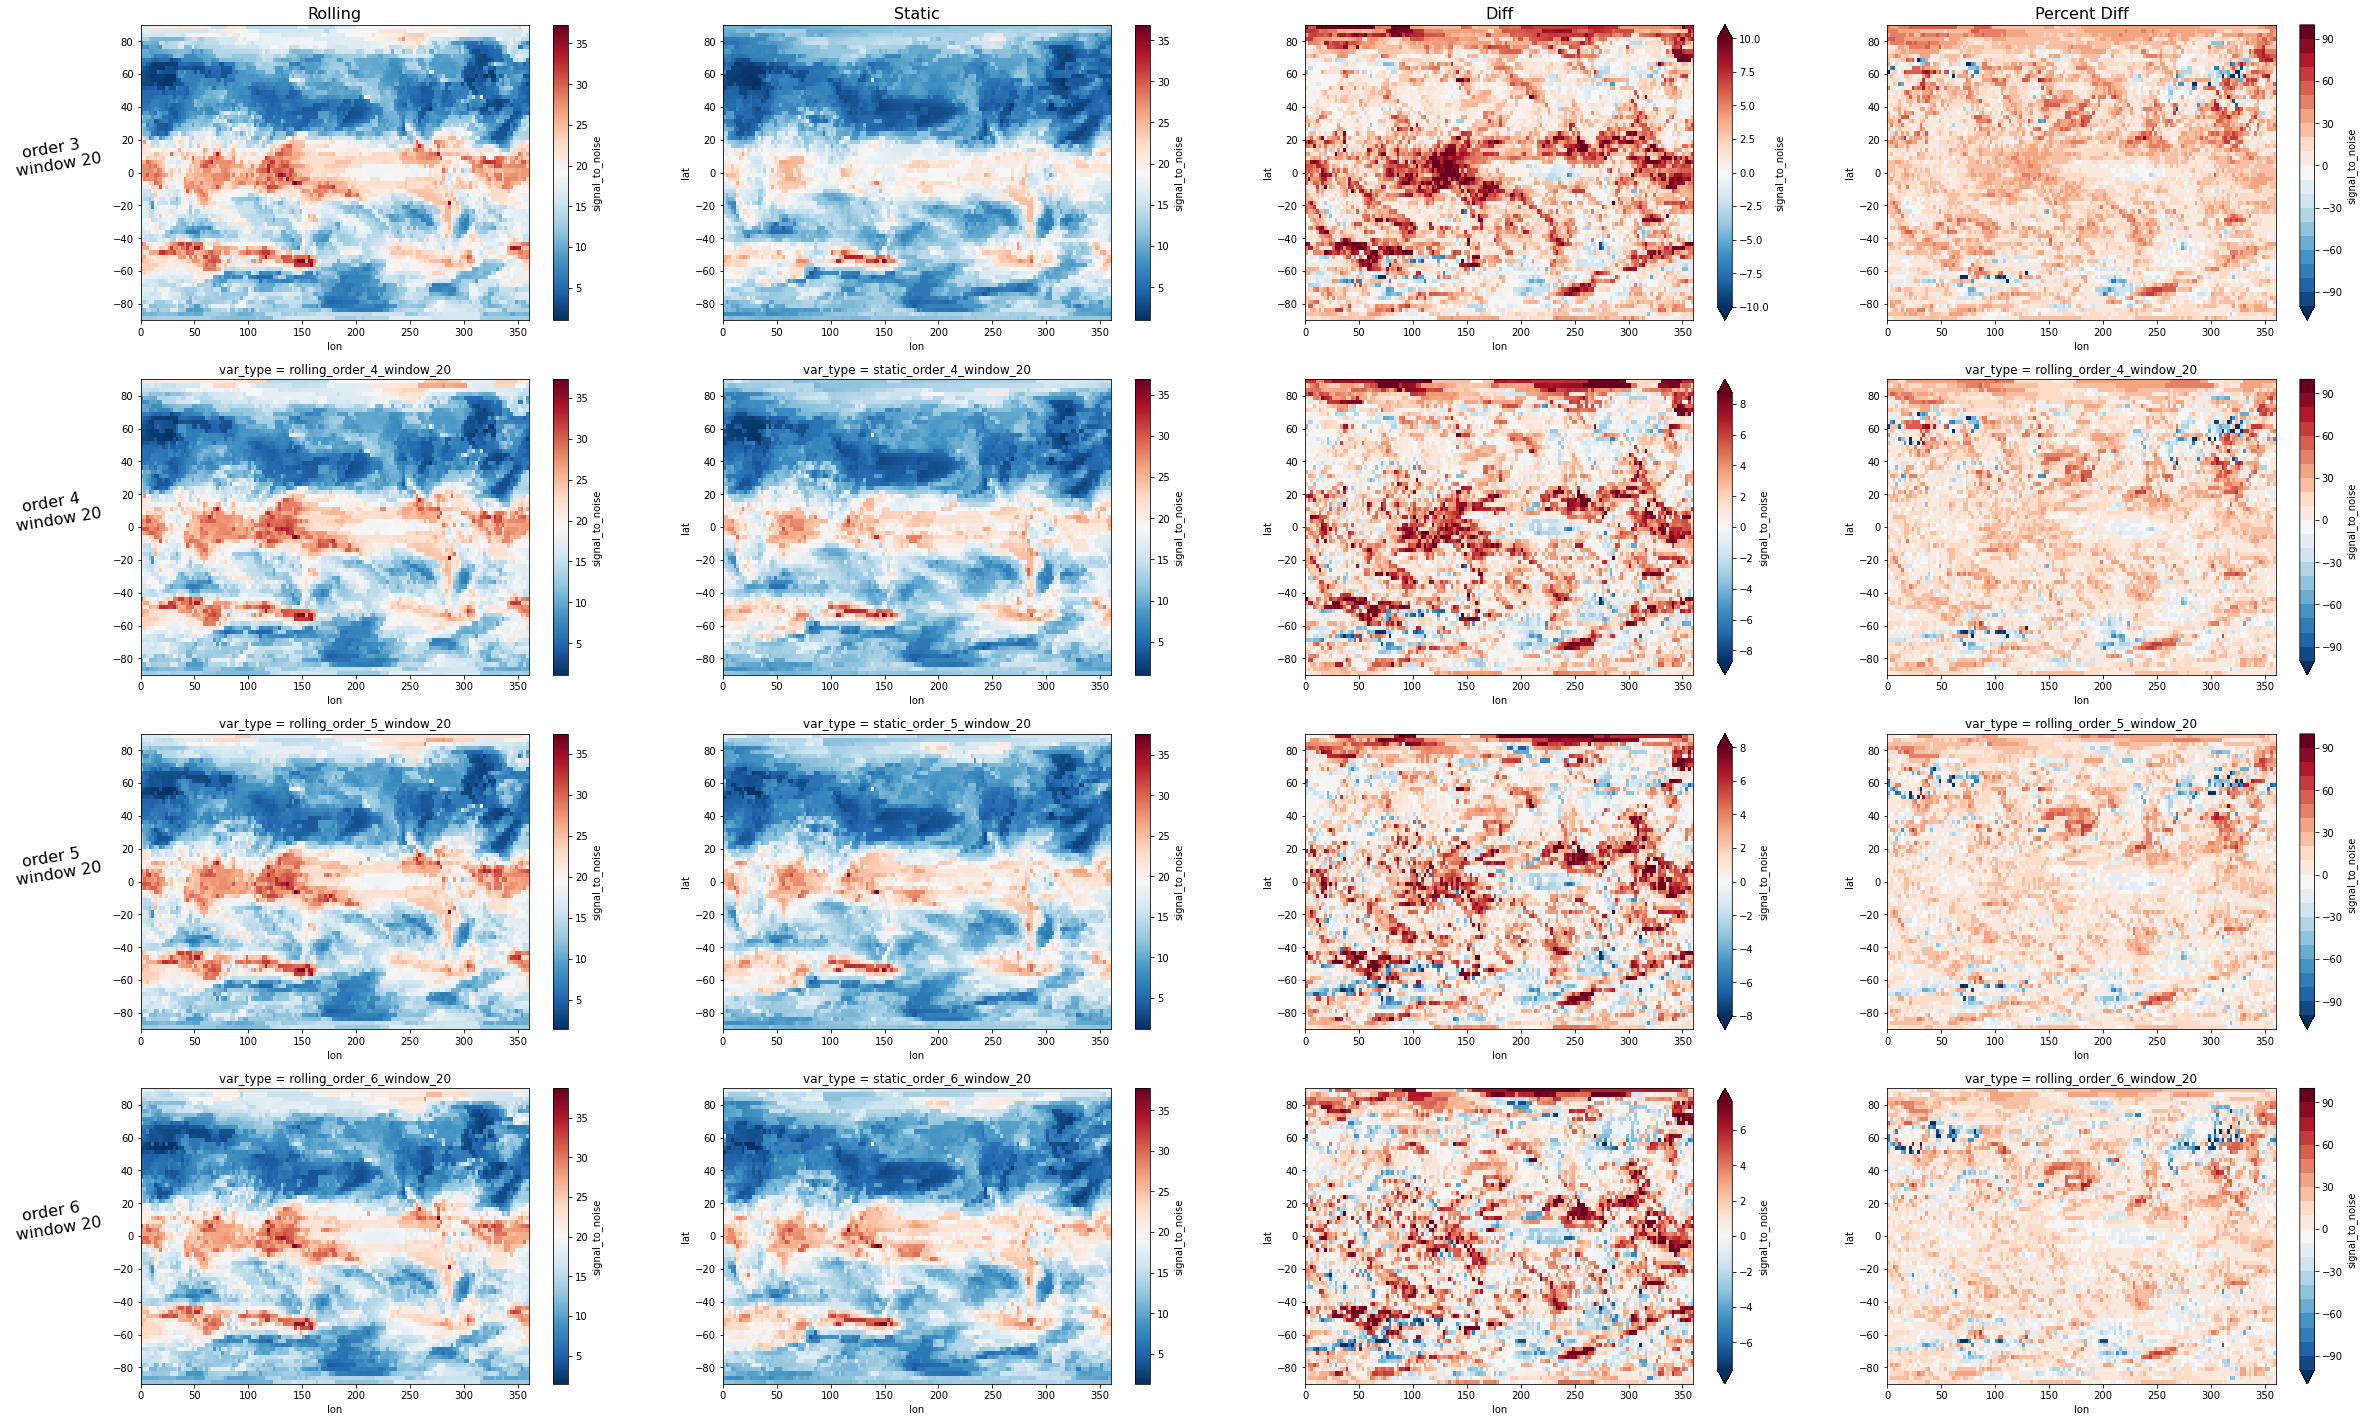

In [174]:
num_cols = 4
num_rows = len(order_window_types)

fig = plt.figure(figsize=(10*num_cols, 25))

gs = gridspec.GridSpec(num_rows, num_cols)

row_num = 0
for order_window in order_window_types:
    axes = [fig.add_subplot(gs[row_num, i]) for i in range(num_cols)]
    
    ds1 = year_stable.sel(var_type = 'rolling_' + order_window).mean(dim='model')
    ds2 = year_stable.sel(var_type = 'static_' + order_window).mean(dim='model')
    diff = ds1-ds2
    percent_diff = diff*100/ds1
    
    ds1.plot(ax=axes[0], cmap=cmap)
    ds2.plot(ax=axes[1], cmap=cmap)
    diff.plot(ax=axes[2], cmap=cmap, robust=True)
    percent_diff.plot(ax=axes[3], cmap=cmap, levels=np.arange(-100, 110, 10))
    
    labels = ['Rolling', 'Static', 'Diff', 'Percent Diff'] if row_num == 0 else ['' * 3]
    if row_num == 0: [ax.set_title(title, fontsize=16) for ax, title in zip(axes, labels)]
        
        
    ylabel = order_window.split('_')
    ylabel.insert(2, '\n')
    ylabel = ' '.join(ylabel)
    axes[0].set_ylabel(ylabel, fontsize=16, rotation=9, labelpad=55)

    row_num+=1
    
fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 'methods_07_local_comparison_polynomial.png'),
           dpi=400, bbox_inches='tight')